# Aligning behavioral data to task events with the stimulus and trials tables
This notebook outlines the stimulus presentations table and the trials table and shows how you can use them to align behavioral data like running, licking and pupil info to task events. Please note that the VBN project used the same detection of change task as the Visual Behavior 2-Photon dataset. Users are encouraged to explore the [documentation](http://portal.brain-map.org/explore/circuits/visual-behavior-2p) and [example notebooks](https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html) for that project for additional context.

Contents
-------------
* <a href='#Introduction-to-the-stimulus-presentations-table'>Introduction to the stimulus presentations table</a>
* <a href='#Introduction-to-the-behavior-trials-table'>Introduction to the behavior trials table</a>
* <a href='#Calculating-response-latency'>Calculating response latency</a>
* <a href='#Aligning-Running,-Licking-and-Pupil-data-to-task-events'>Aligning Running, Licking and Pupil Data to task events</a>

#### Import the cache

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Get the sessions table

In [2]:
# Update this to a valid directory in your filesystem. This is where the data will be stored.
output_dir = "/path/to/vbn_cache"

In [4]:
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(
            cache_dir=Path(output_dir))

ecephys_sessions_table = cache.get_ecephys_session_table()

/home/runner/work/AllenSDK/AllenSDK/allensdk/api/cloud_cache/cloud_cache.py:413: MissingLocalManifestWarning: This cache directory appears to contain data files, but it has no record of what those files are. You might want to consider running

VisualBehaviorNeuropixelsProjectCache.construct_local_manifest()

to avoid needlessly downloading duplicates of data files that did not change between data releases. NOTE: running this method will require hashing every data file you have currently downloaded and could be very time consuming.

To avoid this warning in the future, make sure that

/tmp/tmpy9u4x304/_downloaded_data.json

is not deleted between instantiations of this cache
  warnings.warn(msg, MissingLocalManifestWarning)
ecephys_sessions.csv: 100%|██████████| 64.7k/64.7k [00:00<00:00, 664kMB/s]
behavior_sessions.csv: 100%|██████████| 562k/562k [00:00<00:00, 3.70MMB/s] 
units.csv: 100%|██████████| 132M/132M [00:05<00:00, 22.4MMB/s]
probes.csv: 100%|██████████| 130k/130k [00:00<00:00, 

## Introduction to the stimulus presentations table

Every recording session consisted of three major visual stimulus epochs in the following order (diagrammed below):
- An active behavior session during which the mouse performed the change detection task
- Receptive field mapping and full-field flash stimuli
- 'Passive' replay of stimulus shown during active behavior, but without the lickspout so the mouse can no longer respond.

<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public_thumbnails/filer_public/65/58/6558f0eb-c3c5-45e6-b645-b2e432200804/active_passive_diagram.png__710x291_q90_subsampling-2.png", width="700"/>
</div>

Let's grab a random session and look at the stimulus presentations dataframe to see how these epochs are labeled.

In [5]:
session = cache.get_ecephys_session(
           ecephys_session_id=1065437523)

ecephys_session_1065437523.nwb: 100%|██████████| 3.20G/3.20G [01:40<00:00, 31.7MMB/s]


In [6]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations.columns

Index(['active', 'color', 'contrast', 'duration', 'end_frame',
       'flashes_since_change', 'image_name', 'is_change', 'is_image_novel',
       'omitted', 'orientation', 'position_x', 'position_y', 'rewarded',
       'spatial_frequency', 'start_frame', 'start_time', 'stimulus_block',
       'stimulus_index', 'stimulus_name', 'end_time', 'temporal_frequency',
       'trials_id'],
      dtype='object')

This table is a record of every stimulus we presented to the mouse over the course of this experiment. The different stimuli are indexed by the 'stimulus_block' column. Let's group this dataframe by stimulus block and see what stimulus was shown for each block.

In [7]:
stimulus_presentations.groupby('stimulus_block')[['stimulus_block', 
                                                'stimulus_name', 
                                                'active', 
                                                'duration', 
                                                'start_time']].head(1)

,stimulus_block,stimulus_name,active,duration,start_time
stimulus_presentations_id,,,,,
0,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250188,28.131464
4797,1,spontaneous,False,10.008420,3648.207579
4798,2,gabor_20_deg_250ms,False,0.250208,3658.215999
8443,3,spontaneous,False,288.992998,4570.232761
8444,4,flash_250ms,False,0.250201,4859.225759
8594,5,Natural_Images_Lum_Matched_set_ophys_G_2019,False,0.250213,5183.198085


This shows us the structure of this experiment (and every experiment in this dataset). There are 5 stimuli as follows:

**block 0**: Change detection task. Natural images are flashed repeatedly and the mouse is rewarded for licking when the identity of the image changes. You can find more info about this task [here](http://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels?edit&language=en). Also see [here](https://www.frontiersin.org/articles/10.3389/fnbeh.2020.00104/full) for info about our general training strategy.

**block 1**: Brief gray screen

**block 2**: Receptive field mapping. Gabor stimuli used for receptive field mapping. For more details on this stimulus consult [this notebook](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_receptive_fields.html).

**block 3**: Longer gray screen

**block 4**: Full-field flashes, shown at 80% contrast. Flashes can be black (color = -1) or white (color = 1).

**block 5**: Passive replay. Frame-for-frame replay of the stimulus shown during the change detection task (block 0), but now with the lick spout retracted so the animal can no longer engage in the task.

Here's a quick explanation for each of the columns in this table:

#### General

`active`: Boolean indicating when the change detection task (with the lick spout available to the mouse) was run. This should only be TRUE for block 0.

`stimulus_block`: Index of stimulus as described in cells above.

`stimulus_name`: Indicates the stimulus category for this stimulus presentation. 

`contrast`: Stimulus contrast as defined [here](https://www.psychopy.org/api/visual/gratingstim.html#psychopy.visual.GratingStim.contrast)

`duration`: Duration of stimulus in seconds

`start_time`: Experiment time when stimulus started. This value is corrected for display lag and therefore indicates when the stimulus actually appeared on the screen.

`end_time`: Experiment time when stimulus ended, also corrected for display lag.

`start_frame`: Stimulus frame index when this stimulus started. This can be used to sync this table to the behavior trials table, for which behavioral data is collected every frame.

`end_frame`: Stimulus frame index when this stimulus ended.

#### Change detection task and Passive replay (blocks 0 and 5)

`flashes_since_change`: Indicates how many flashes of the same image have occurred since the last stimulus change.

`image_name`: Indicates which natural image was flashed for this stimulus presentation. To see how to visualize this image, check out [this tutorial](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/visual_behavior_neuropixels_data_access.html).

`is_change`: Indicates whether the image identity changed for this stimulus presentation. When both this value and 'active' are TRUE, the mouse was rewarded for licking within the response window.

`omitted`: Indicates whether the image presentation was omitted for this flash. Most image flashes had a 5% probability of being omitted (producing a gray screen). Flashes immediately preceding a change or immediately following an omission could not be omitted.

`rewarded`: Indicates whether a reward was given after this image presentation. During the passive replay block (5), this value indicates that a reward was issued for the corresponding image presentation during the active behavior block (0). No rewards were given during passive replay.

#### Receptive field mapping gabor stimulus (block 2)

`orientation`: Orientation of gabor. 

`position_x`: Position of the gabor along azimuth. The units are in degrees relative to the center of the screen (negative values are nasal).

`position_y`: Position of the gabor along elevation. Negative values are lower elevation.

`spatial_frequency`: Spatial frequency of gabor in cycles per degree.

`temporal_frequency`: Temporal frequency of gabor in Hz.

#### Full field flashes (block 4)

`color`: Color of the full-field flash stimuli. "1" is white and "-1" is black.


Let's confirm that the active behavior block (0) and the passive replay block (5) match frame for frame:

In [8]:
active_image_presentations = stimulus_presentations[stimulus_presentations['stimulus_block']==0]
passive_image_presentations = stimulus_presentations[stimulus_presentations['stimulus_block']==5]
np.all(active_image_presentations['image_name'].values == passive_image_presentations['image_name'].values )

True

Taking block 0 as an example, let's look at the timing of the stimuli. As a reminder, each flash was presented for 250 ms with 500 ms interflash intervals. In addition, flashes were occasionally omitted to investigate expectation signals:

<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public_thumbnails/filer_public/e7/de/e7de5da4-a19f-4ef6-9bc3-3a5b088048ac/task_diagram.png__2320x419_q90_subsampling-2.png", width="900"/>
</div>

Now let's check the timing of our flashes and see how it compares to our intended timing:

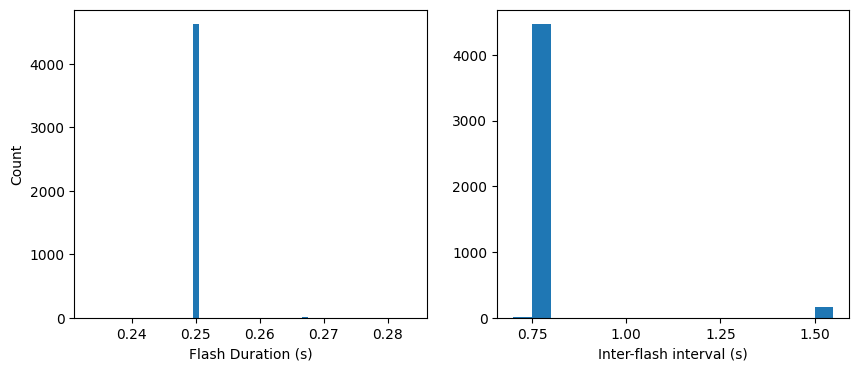

In [9]:
#get the active behavior part of the stim table
active_behavior = stimulus_presentations[stimulus_presentations['active']==True]

#for now, let's leave out the omitted stimuli
active_behavior_no_omissions = active_behavior[active_behavior['omitted']==False]

#plot histogram of the stimulus durations
fig, axes = plt.subplots(1, 2)
fig.set_size_inches([10,4])
_ =  axes[0].hist(active_behavior_no_omissions.duration, 50)
axes[0].set_xlabel('Flash Duration (s)')
axes[0].set_ylabel('Count')

inter_flash = active_behavior_no_omissions['start_time'].diff()
_ = axes[1].hist(inter_flash, np.arange(0.7, 1.6, 0.05))
axes[1].set_xlabel('Inter-flash interval (s)')
axes[1].set_xticks(np.arange(0.75, 1.6, 0.25))

Looks like the flash duration and interflash intervals are generally what we expect. Note though that a number of inter-flash intervals are twice as long as expected (1.5 s). This is because a small percentage of flashes are omitted. The chance of omitting a flash is nominally 5%, but we've also added two extra criteria:

- two omissions can't happen in a row
- an omission can't directly precede the change

This makes the actual chances of an omission a bit less than 5%:

In [10]:
#look at the percentage of flashes that were omissions
np.sum(active_behavior.omitted)/len(active_behavior)

0.03418803418803419

## Introduction to the behavior trials table

Now let's explore the behavior trials table. This table contains lots of useful information about every trial in the change detection task.

In [11]:
trials = session.trials
trials.head()

,start_time,stop_time,initial_image_name,change_image_name,is_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
0,28.08763,29.05453,im036_r,im036_r,False,NaN,False,False,"[28.55387, 28.73684, 29.30404]",NaN,NaN,0.000,False,False,False,False,True,False,NaN,0.96690
1,29.58829,36.86108,im036_r,im078_r,True,32.59106,False,False,"[33.04048, 33.20773, 33.30745, 33.3908, 33.507...",33.04048,32.74138,0.005,False,False,False,False,False,True,330.0,7.27279
2,37.09446,40.78107,im078_r,im078_r,False,NaN,False,False,[40.48052],NaN,NaN,0.000,False,False,False,False,True,False,NaN,3.68661
3,40.84754,50.37230,im078_r,im111_r,True,46.10256,False,False,"[46.73531, 46.83539, 46.95218, 47.06898, 47.20...",46.73531,46.25277,0.005,False,False,False,False,False,True,1140.0,9.52476
4,50.60569,51.75679,im111_r,im111_r,False,NaN,False,False,[51.43985],NaN,NaN,0.000,False,False,False,False,True,False,NaN,1.15110


Unlike the stimulus presentations table in which every row corresponded to a visual stimulus presentation, for the behavior trials table every row corresponds to one trial of the change detection task. Here is a quick summary of the columns:

`start_time`: Experiment time when this trial began in seconds.

`end_time`: Experiment time when this trial ended.

`initial_image_name`: Indicates which image was shown before the change (or sham change) for this trial

`change_image_name`: Indicates which image was scheduled to be the change image for this trial. Note that if the trial is aborted, a new trial will begin before this change occurs.

`stimulus_change`: Indicates whether an image change occurred for this trial. 

`change_time_no_display_delay`: Experiment time when the task-control computer commanded an image change. This change time is used to determine the response window during which a lick will trigger a reward. Note that due to display lag, this is not the time when the change image actually appears on the screen. To get this time, you need the stimulus_presentations table (more about this below).

`go`: Indicates whether this trial was a 'go' trial. To qualify as a go trial, an image change must occur and the trial cannot be autorewarded.

`catch`: Indicates whether this trial was a 'catch' trial. To qualify as a catch trial, a 'sham' change must occur during which the image identity does not change. These sham changes are drawn to match the timing distribution of real changes and can be used to calculate the false alarm rate.

`lick_times`: A list indicating when the behavioral control software recognized a lick. Note that this is not identical to the lick times from the licks dataframe, which record when the licks were registered by the lick sensor. The licks dataframe should generally be used for analysis of the licking behavior rather than these times.

`response_time`: Indicates the time when the first lick was registered by the task control software for trials that were not aborted (go or catch). NaN for aborted trials. For a more accurate measure of response time, the licks dataframe should be used.

`reward_time`: Indicates when the reward command was triggered for hit trials. NaN for other trial types. 

`reward_volume`: Indicates the volume of water dispensed as reward for this trial. 

`hit`: Indicates whether this trial was a 'hit' trial. To qualify as a hit, the trial must be a go trial during which the stimulus changed and the mouse licked within the reward window (150-750 ms after the change time).

`false_alarm`: Indicates whether this trial was a 'false alarm' trial. To qualify as a false alarm, the trial must be a catch trial during which a sham change occurred and the mouse licked during the reward window.

`miss`: To qualify as a miss trial, the trial must be a go trial during which the stimulus changed but the mouse did not lick within the response window.

`correct_reject`: To qualify as a correct reject trial, the trial must be a catch trial during which a sham change occurred and the mouse withheld licking.

`aborted`: A trial is aborted when the mouse licks before the scheduled change or sham change.

`auto_rewarded`: During autorewarded trials, the reward is automatically triggered after the change regardless of whether the mouse licked within the response window. These always come at the beginning of the session to help engage the mouse in behavior.

`change_frame`: Indicates the stimulus frame index when the change (on go trials) or sham change (on catch trials) occurred. This column can be used to link the trials table with the stimulus presentations table, as shown below.

`trial_length`: Duration of the trial in seconds.

## Calculating response latency

Let's combine info from both of these tables to calculate response latency for this session. Note that the change time in the trials table is not corrected for display lag. This is the time that the task control computer used to determine the response window. However, to calculate response latency, we want to use the display lag *corrected* change times from the stimulus presentations table. Below, we will grab these corrected times and add them to the trials table under the new column label `change_time_with_display_delay`.

In [12]:
def get_change_time_from_stim_table(row):
    '''
    Given a particular row in the trials table,
    find the corresponding change time in the 
    stimulus presentations table
    '''
    table = stimulus_presentations
    change_frame = row['change_frame']
    if np.isnan(change_frame):
        return np.nan
    
    change_time = table[table.start_frame==change_frame]\
                    ['start_time'].values[0]
    
    return change_time

change_times = trials.apply(get_change_time_from_stim_table, axis=1)
trials['change_time_with_display_delay'] = change_times

Now we can use this new column to calculate the response latency on 'hit' trials. First, we'll need to get the lick times for this session:

In [13]:
# get the licks table
licks = session.licks

Then we'll use these to get the response latency:

Text(0, 0.5, 'Trial count')

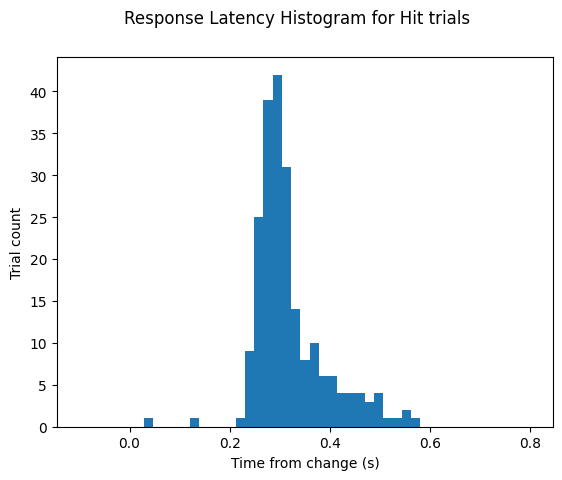

In [14]:
# filter for the hit trials
hit_trials = trials[trials['hit']]

# find the time of the first lick after each change
lick_indices = np.searchsorted(licks.timestamps, hit_trials['change_time_with_display_delay'])
first_lick_times = licks.timestamps.values[lick_indices]
response_latencies = first_lick_times - hit_trials['change_time_with_display_delay']

# plot the latencies
fig, ax = plt.subplots()
fig.suptitle('Response Latency Histogram for Hit trials')
ax.hist(response_latencies, bins=np.linspace(-0.1, 0.8, 50))
ax.set_xlabel('Time from change (s)')
ax.set_ylabel('Trial count')

## Aligning Running, Licking and Pupil data to task events

Now let's grab the licking, running and pupil tracking data for this session and align it to the behavior.

In [15]:
eye_tracking = session.eye_tracking
running_speed = session.running_speed
licks = session.licks

**Eye tracking dataframe**: One entry containing ellipse fit parameters for the eye, pupil and corneal reflection for every frame of the eye tracking video stream.

In [16]:
eye_tracking.head()

,timestamps,cr_area,eye_area,pupil_area,likely_blink,pupil_area_raw,cr_area_raw,eye_area_raw,cr_center_x,cr_center_y,...,eye_center_x,eye_center_y,eye_width,eye_height,eye_phi,pupil_center_x,pupil_center_y,pupil_width,pupil_height,pupil_phi
frame,,,,,,,,,,,,,,,,,,,,,
0,1.98179,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.99846,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.01512,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.03179,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.04846,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There seem to be several rows for which there are no valid data. We can use the 'likely_blink' column to filter these out.

In [17]:
eye_tracking_noblinks = eye_tracking[~eye_tracking['likely_blink']]
eye_tracking_noblinks.head()

,timestamps,cr_area,eye_area,pupil_area,likely_blink,pupil_area_raw,cr_area_raw,eye_area_raw,cr_center_x,cr_center_y,...,eye_center_x,eye_center_y,eye_width,eye_height,eye_phi,pupil_center_x,pupil_center_y,pupil_width,pupil_height,pupil_phi
frame,,,,,,,,,,,,,,,,,,,,,
16,2.69844,143.319910,64100.607811,18344.446003,False,18344.446003,143.319910,64100.607811,307.495920,253.050384,...,293.215171,252.429377,154.298080,132.236624,-0.045388,296.119363,245.965454,76.414779,75.552596,0.186599
17,2.71512,144.637343,64128.814923,18500.396156,False,18500.396156,144.637343,64128.814923,307.703577,252.995883,...,293.465116,252.383047,154.610779,132.027248,-0.047398,296.156537,246.179364,76.738901,75.066741,0.071866
18,2.73178,138.430143,64228.144166,18768.526187,False,18768.526187,138.430143,64228.144166,307.929085,253.125091,...,293.563823,252.333781,154.851436,132.026242,-0.049470,296.457157,245.953752,77.292997,75.030102,0.000100
19,2.74845,140.384821,64356.597629,18790.177151,False,18790.177151,140.384821,64356.597629,307.710460,253.179979,...,293.503738,252.582299,154.705897,132.414741,-0.049801,296.389647,246.022947,77.337566,75.251635,0.004288
20,2.76511,153.408346,64446.974420,18824.413215,False,18824.413215,153.408346,64446.974420,307.556380,253.339529,...,293.251817,252.265215,154.720970,132.587775,-0.040922,296.259293,246.003218,77.407989,75.440085,-0.036076


**Running dataframe**: One entry for each read of the analog input line monitoring the encoder voltage, polled at ~60 Hz.

In [18]:
running_speed.head()

,timestamps,speed
0,27.11889,21.929034
1,27.13549,31.705640
2,27.15263,40.125461
3,27.16893,46.906969
4,27.18556,51.945394


**Licking dataframe**: One entry for every detected lick onset time,

In [19]:
licks.head()

,timestamps,frame
0,28.55104,88
1,28.72504,99
2,29.30011,133
3,33.02635,357
4,33.20237,367


Now let's take a look at running, licking and pupil area for one reward trial

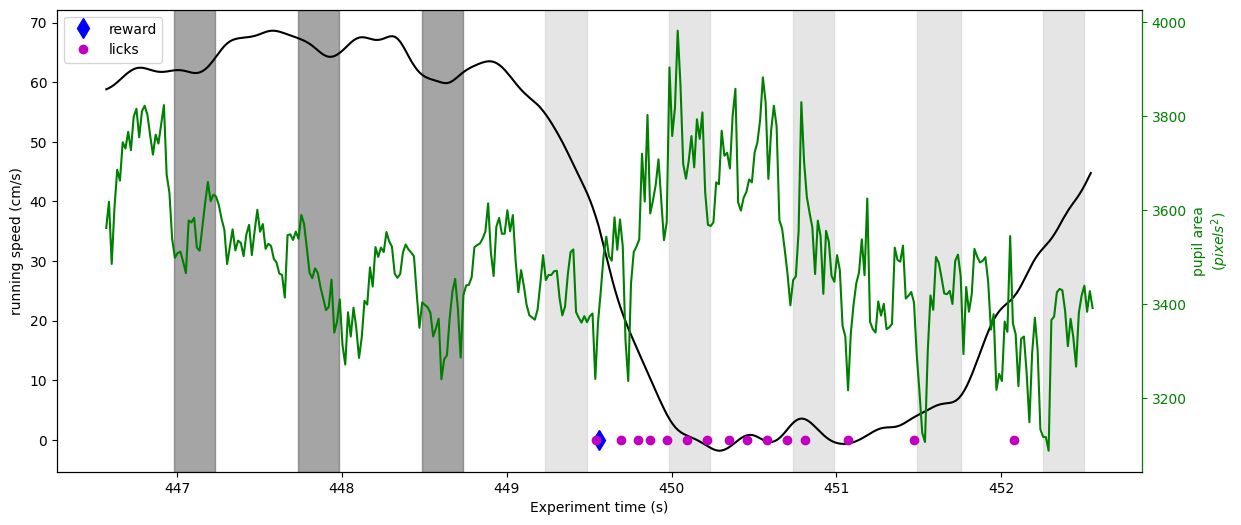

In [20]:
time_before = 3.0 #how much time to plot before the reward
time_after = 3.0 #how much time to plot after the reward
reward_time = session.rewards.iloc[15]['timestamps'] #get a random reward time

#Get running data aligned to this reward
trial_running = running_speed.query('timestamps >= {} and timestamps <= {} '.
                                    format(reward_time-time_before, reward_time+time_after))

#Get pupil data aligned to this reward
trial_pupil_area = eye_tracking_noblinks.query('timestamps >= {} and timestamps <= {} '.
                                    format(reward_time-time_before, reward_time+time_after))

#Get stimulus presentations around this reward
behavior_presentations = stimulus_presentations[stimulus_presentations['active']]
behavior_presentations = behavior_presentations[(behavior_presentations['omitted']==False)]
trial_stimuli = behavior_presentations.query('end_time >= {} and start_time <= {}'.
                                             format(reward_time-time_before, reward_time+time_after))

#Get licking aligned to this reward
trial_licking = licks.query('timestamps >= {} and timestamps <= {} '.
                                    format(reward_time-time_before, reward_time+time_after))


#Plot running, pupil area and licks
fig, axr = plt.subplots()
fig.set_size_inches(14,6)
axr.plot(trial_running['timestamps'], trial_running['speed'], 'k')
axp = axr.twinx()
axp.plot(trial_pupil_area['timestamps'], trial_pupil_area['pupil_area'], 'g')
rew_handle, = axr.plot(reward_time, 0, 'db', markersize=10)
lick_handle, = axr.plot(trial_licking['timestamps'], np.zeros(len(trial_licking['timestamps'])), 'mo')
axr.legend([rew_handle, lick_handle], ['reward', 'licks'])

axr.set_ylabel('running speed (cm/s)')
axp.set_ylabel('pupil area\n$(pixels^2)$')
axr.set_xlabel('Experiment time (s)')

axp.yaxis.label.set_color('g')
axp.spines['right'].set_color('g')
axp.tick_params(axis='y', colors='g')

#Plot the image flashes as grey bars. 
colors = ['0.3', '0.8']
stimulus_colors = {stim: c for stim,c in zip(trial_stimuli['image_name'].unique(), colors)}
for idx, stimulus in trial_stimuli.iterrows():
    axr.axvspan(stimulus['start_time'], stimulus['end_time'], color=stimulus_colors[stimulus['image_name']], alpha=0.5)

Here we can see that just after the stimulus change (a little past 449 seconds), the mouse abruptly stops running and begins licking. The reward is delivered shortly after the first lick. We can also begin to see that before the change the pupil and running become entrained to the image flashes.